In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/GitHub/Optimal-Control-16-745/lecture-notebooks/Lecture 8/Project.toml`


In [2]:
using LinearAlgebra
using PyPlot
using SparseArrays
using ControlSystems
using ForwardDiff

[ Info: Precompiling ControlSystems [a6e380b2-a6ca-5380-bf3e-84a91bcd477e]
┌ Warning: Replacing docs for `SciMLBase.sol :: Union{Tuple, Tuple{D}, Tuple{S}, Tuple{N}, Tuple{T}} where {T, N, S, D}` in module `SciMLBase`
└ @ Base.Docs docs/Docs.jl:240


In [4]:
# Discrete dynamics
h = 0.1   # time step
A = [1 h; 0 1]
B = [0.5*h*h; h]

2-element Vector{Float64}:
 0.005000000000000001
 0.1

In [5]:
#Controllability
rank([B A*B])

2

In [6]:
n = 2     # number of state
m = 1     # number of controls
Tfinal = 10.0 # final time
N = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(N-1), step=h));

In [7]:
# Initial conditions
x0 = [1.0; 0]

2-element Vector{Float64}:
 1.0
 0.0

In [8]:
# Cost weights
Q = Array(1.0*I(n))
R = Array(0.1*I(m))
Qn = Array(1.0*I(n))

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

In [9]:
#Cost function
function J(xhist,uhist)
    cost = 0.5*xhist[:,end]'*Qn*xhist[:,end]
    for k = 1:(size(xhist,2)-1)
        cost = cost + 0.5*xhist[:,k]'*Q*xhist[:,k] + 0.5*(uhist[k]'*R*uhist[k])[1]
    end
    return cost
end

J (generic function with 1 method)

In [10]:
#Cost-to-go Function
function Vinf(x)
    return 0.5*x'*Pinf*x
end

function V(k,x)
    return 0.5*x'*P[:,:,k]*x
end

V (generic function with 1 method)

In [11]:
#QP Solution for xhist, uhist
# Cost
H = blockdiag(sparse(R), kron(I(N-2), blockdiag(sparse(Q),sparse(R))), sparse(Qn));

In [12]:
# Constraints
C = kron(I(N-1), [B -I(2)])
for k = 1:N-2
    C[(k*n).+(1:n), (k*(n+m)-n).+(1:n)] .= A
end
d = [-A*x0; zeros(size(C,1)-n)];

In [13]:
# Solve the linear system
y = [H C'; C zeros(size(C,1),size(C,1))]\[zeros(size(H,1)); d]

# Get multipliers
λhist_qp = reshape(y[(size(H,1)+1):end],n,N-1)

# Get state history
z = y[1:size(H,1)]   # states and controls [u0,x1,u1,...,xN]
Z = reshape(z,n+m,N-1)
xhist_qp = Z[m+1:end,:]
xhist_qp = [x0 xhist_qp]

# Get control history
uhist_qp = Z[1,:];

In [14]:
#Dynamic Programming Solution for P and K
P = zeros(n,n,N)
K = zeros(m,n,N-1)

P[:,:,N] .= Qn

#Backward Riccati recursion
for k = (N-1):-1:1
    K[:,:,k] .= (R .+ B'*P[:,:,k+1]*B)\(B'*P[:,:,k+1]*A)
    P[:,:,k] .= Q + K[:,:,k]'*R*K[:,:,k] + (A-B*K[:,:,k])'*P[:,:,k+1]*(A-B*K[:,:,k])
end

#Forward rollout starting at x0
xhist = zeros(n,N)
xhist[:,1] = x0
uhist = zeros(m,N-1)
for k = 1:(N-1)
    uhist[:,k] .= -K[:,:,k]*xhist[:,k]
    xhist[:,k+1] .= A*xhist[:,k] + B*uhist[k]
end

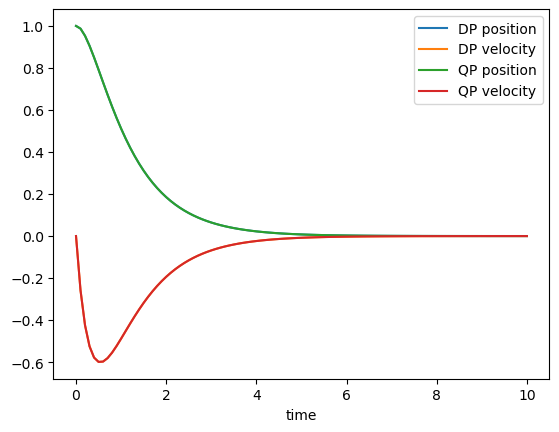

PyObject <matplotlib.legend.Legend object at 0x179f32290>

In [15]:
# Plot x1 vs. x2, u vs. t, x vs. t, etc.
times = range(0,h*(N-1), step=h)
plot(times,xhist[1,:], label="DP position")
plot(times,xhist[2,:], label="DP velocity")
plot(times,xhist_qp[1,:], label="QP position")
plot(times,xhist_qp[2,:], label="QP velocity")
xlabel("time")
legend()

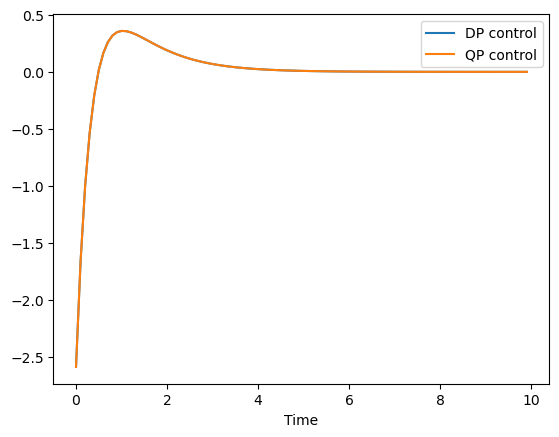

PyObject <matplotlib.legend.Legend object at 0x17f1af7f0>

In [16]:
plot(times[1:end-1], uhist[1,:], label="DP control")
plot(times[1:end-1], uhist_qp, label="QP control")
xlabel("Time")
legend()

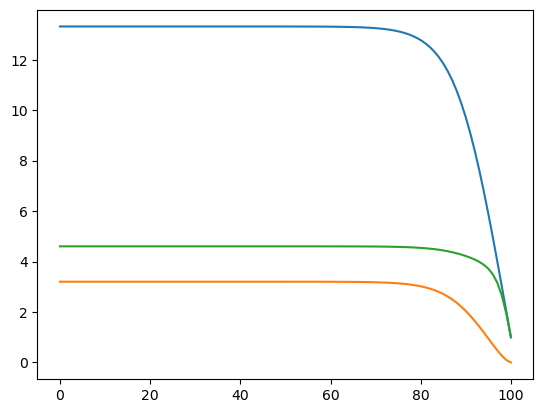

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x17f34d8a0>

In [17]:
plot(P[1,1,:])
plot(P[1,2,:])
plot(P[2,2,:])

In [18]:
J(xhist,uhist)

6.658612208961312

In [19]:
J(xhist_qp,uhist_qp)

6.658612208961312

In [20]:
#Compute infinite-horizon K matrix using ControlSystems.jl
Kinf = dlqr(A,B,Q,R[1])
#Compare to ours
K[:,:,1]-Kinf

1×2 Matrix{Float64}:
 -6.72929e-9  -2.28764e-9

In [21]:
#Compute infinite-horizon P matrix
Pinf = dare(A,B,Q,R)
#Compare to ours
P[:,:,1] - Pinf

2×2 Matrix{Float64}:
 -2.32084e-8  -7.88974e-9
 -7.88974e-9  -2.68213e-9

In [22]:
#Forward rollout starting at xk
function rollout(k,x)
    xsub = zeros(n,N-k+1)
    xsub[:,1] .= x
    usub = zeros(m,N-k)
    for j = k:(N-1)
        usub[:,j-k+1] .= -K[:,:,j]*xsub[:,j-k+1]
        xsub[:,j-k+2] .= A*xsub[:,j-k+1] + B*usub[j-k+1]
    end
    return xsub,usub
end

rollout (generic function with 1 method)

In [23]:
#Generate a sub-trajectory starting at xk
k = 50
xsub, usub = rollout(k,xhist[:,k])

([0.008565027630146473 0.007701497232424686 … 6.952721258612016e-5 6.689502637287264e-5; -0.0090937170650696 -0.008176890889366142 … -2.741601026646724e-5 -2.5227713998483276e-5], [0.009168261757034585 0.008244198746429749 … 3.913310967971362e-5 2.188296267983964e-5])

In [24]:
#Optimal state sub-trajectories are optimal
xsub - xhist[:,k:end]

2×52 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [25]:
#Optimal control sub-trajectories are optimal
usub - uhist[:,k:end]

1×51 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [26]:
#Compare multipliers from QP to Cost-to-go gradient from DP
λhist_qp[:,k-1]

2-element Vector{Float64}:
  0.08494405503397162
 -0.014443027451912923

In [27]:
ForwardDiff.gradient(x->V(k,x),xhist[:,k])

2-element Vector{Float64}:
  0.08494405503397173
 -0.014443027451912924

In [28]:
#Also compare to infinite horizon
ForwardDiff.gradient(x->Vinf(x),xhist[:,k])

2-element Vector{Float64}:
  0.08494829522129739
 -0.014441586030909595

In [29]:
#Let's try finite diffing the cost w.r.t. the state
x1p, u1p = rollout(k,xhist[:,k]+[1e-6; 0])
x2p, u2p = rollout(k,xhist[:,k]+[0; 1e-6])
λfd = [J(x1p,u1p) - J(xhist[:,k:end],uhist[:,k:end]), J(x2p,u2p) - J(xhist[:,k:end],uhist[:,k:end])]./1e-6

2-element Vector{Float64}:
  0.08495071325879087
 -0.014440725739652514